In [1]:
--------------------------------------------------------------------------------
-- Loading dataset to ram and sorting triplets
--------------------------------------------------------------------------------
-- Alfredo Canziani, Apr 15
--------------------------------------------------------------------------------

require 'image'
require 'sys'
require 'xlua'

-- set to 1 if using GPU
cuda = 1
if cuda == 1 then
    require 'cunn'
    require 'cutorch'
end

torch.setdefaulttensortype('torch.FloatTensor')

local dataset = {}
local imageSide = 120


-- Loading the dataset to RAM --------------------------------------------------
if paths.filep('dataset.t7') then
   io.write('Loading whole data set. Please wait...'); io.flush()
   dataset = torch.load('dataset.t7')
   print(' Done.')
else
   -- This script uses pubfig83.v1.tgz from http://vision.seas.harvard.edu/pubfig83/
   -- split in train and test folders
   -- each containing identities folders with images inside.
   -- Format:
   -- datasetRoot/{train,test}/<celebrityName>
   local datasetPaths = {}
   datasetPaths.base = 'pubfig83'

   for _, t in ipairs {'train', 'test'} do
      print('Building ' .. t .. 'ing data set')

      datasetPaths[t] = datasetPaths.base .. '/' .. t .. '/'
      local identities = sys.ls(datasetPaths[t]):split('\n')
        print(identities)
      local dataSize = tonumber(sys.execute('find ' .. datasetPaths[t] .. ' -iname "*.jpg"| wc -l'))
        print(dataSize)
      dataset[t] = {
         data = torch.Tensor(dataSize, 3, imageSide, imageSide),
         label = torch.Tensor(dataSize),
         index = torch.Tensor(#identities, 2),
      }

        
      local count = 0
      for id, idName in ipairs(identities) do
         dataset[t].index[id][1] = count + 1
         for _, img in ipairs(sys.ls(datasetPaths[t] .. idName):split('\n')) do
            count = count + 1
            xlua.progress(count, dataSize)
            -- print(count, paths.concat(datasetPaths[t], idName, img))
            local original = image.load(paths.concat(datasetPaths[t], idName, img))
            local h = original:size(2)
            local w = original:size(3)
            local m = math.min(h, w)
            local y = math.floor((h - m) / 2)
            local x = math.floor((w - m) / 2)
            dataset[t].data[count] = image.scale(
               original[{ {}, {y + 1, y + m}, {x + 1, x + m} }],
               imageSide, imageSide
            )
            dataset[t].label[count] = id
         end
         dataset[t].index[id][2] = count
         collectgarbage()
      end
   end

   io.write('Saving whole data set to disk...'); io.flush()
   torch.save('dataset.t7', dataset)
   print(' Done.')

    collectgarbage();
end


-- Private functions -----------------------------------------------------------
-- Training shuffle
local shuffle

-- New index table for t: train/test
local shuffleShuffle = function(t)
   shuffle = torch.randperm(dataset[t].data:size(1))
end


-- Get nb of (train and test) batches gives the batch size
local nbOfBatches = {}
local batchSize, pImgs
local getNbOfBatches = function(bS)
   batchSize = bS
   for _, t in ipairs {'train', 'test'} do
      nbOfBatches[t] = math.floor(dataset[t].data:size(1) / batchSize)
   end
   pImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   return nbOfBatches
end


-- Initialise the (train and test) embeddings
local embSize
local initEmbeddings = function(eS)
   embSize = eS
   for _, t in ipairs {'train', 'test'} do
      dataset[t].emb = torch.randn(dataset[t].data:size(1), embSize)
      dataset[t].emb = dataset[t].emb:cdiv(dataset[t].emb:norm(2, 2):repeatTensor(1, embSize))
        print(dataset[t])
   end
   print('Training and testing embeddings initialised with size ' .. embSize)
end


-- Get batch number nb for the t (train/test) dataset
-- <mode> by default is 'hard-neg' but can be set to 'soft-neg'
local pEmb
local getBatch = function(nb, t, mode, epoch)

   -- Main varialbles
   local aImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   local nImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   local emb = torch.Tensor(batchSize, embSize)

   -- Auxiliary variables
   local labels = torch.Tensor(batchSize)
   local offset = batchSize * (nb - 1)
    
    print('pass 0')
    
   -- Populating anchor and positive images batches
   for i = 1, batchSize do
      local loc = shuffle[i + offset] -- original location in data set
      print('off good')
      aImgs[i]  = dataset[t].data [loc]
      print('off good')
      emb[i]    = dataset[t].emb  [loc]
    print('off good')
      labels[i] = dataset[t].label[loc]
        print('off good')
      if mode ~= 'soft-neg2' then
         pImgs[i]  = dataset[t].data [math.random(
            dataset[t].index[labels[i]][1],
            dataset[t].index[labels[i]][2]
         )]
      end
   end
    
    
    print('pass 1')

   -- Populating negative images batche
   local mode = mode or 'hard-neg'
   if mode == 'hard-neg' then
      for i = 1, batchSize do
         local diff = emb - emb[{ {i} }]:expandAs(emb)
         local norms = diff:norm(2, 2):squeeze()
         norms[labels:eq(labels[i])] = norms:max()
         local _, nIdx = norms:min(1) -- closest n-emb to a-emb
         nImgs[i] = aImgs[nIdx[1]]
      end
   elseif mode == 'soft-neg1' then
      -- do nothing
   elseif mode == 'soft-neg2' then
      for i = 1, batchSize do
         local diff = emb - emb[{ {i} }]:expandAs(emb)
         local norms = diff:norm(2, 2):squeeze()
         norms = norms - torch.Tensor(batchSize):fill((emb[i]-pEmb[i]):norm())
         norms[labels:eq(labels[i])] = norms:max()
         norms[norms:lt(0)] = norms:max()
         local _, nIdx = norms:min(1) -- closest n-emb to a-emb
         nImgs[i] = aImgs[nIdx[1]]
      end
   else error('Negative populating <mode> not recognised!')
   end

   return {aImgs, pImgs, nImgs}

end


-- Moves the batch to the GPU's RAM
local toCuda = function(batch)
   require 'cutorch'
   for i in ipairs(batch) do batch[i] = batch[i]:cuda() end
end


-- Saves the embeddings emb for the nb batch of t (train/test) data set
local saveEmb = function(emb, nb, t, posEmb)
   local offset = batchSize * (nb - 1)
   for i = 1, batchSize do
      dataset[t].emb[shuffle[i + offset]] = emb[i]:float()
   end
   if posEmb then pEmb = posEmb:float() end
end

local getDataset = function()
    
end

-- Public functions ------------------------------------------------------------
return {
   select         = shuffleShuffle,
   getNbOfBatches = getNbOfBatches,
   initEmbeddings = initEmbeddings,
   getBatch       = getBatch,
   toCuda         = toCuda,
   saveEmb        = saveEmb,
}

Loading whole data set. Please wait...

 Done.	


In [2]:
collectgarbage();

In [3]:
torch.manualSeed(0)
math.randomseed(0)

data = require 'data'

-- Shuffling training data
data.select('train') -- or 'test'

-- Initialise embeddings
embDim = 5
data.initEmbeddings(embDim)

-- Get train and test number of batches
batchDim = 10
trainBatches = data.getNbOfBatches(batchDim).train
print('trainBatches: ', trainBatches)

-- Get training batch nb 1
batch = data.getBatch(1, 'train')
print('batch = {aImg, pImg, nImg}: ', batch)

-- Send batch to cuda
--collectgarbage()
--data.toCuda(batch)
--print('Batch sent to GPU memory')

-- Saving embeddings
data.saveEmb(torch.randn(batchDim, embDim), 1, 'train')
print('Embedding saved for fast training')


Loading whole data set. Please wait...

 Done.	


Training and testing embeddings initialised with size 5	
trainBatches: 	5874	


batch = {aImg, pImg, nImg}: 	{
  1 : FloatTensor - size: 10x3x120x120
  2 : FloatTensor - size: 10x3x120x120
  3 : FloatTensor - size: 10x3x120x120
}
Embedding saved for fast training	


In [4]:
function printTriplets(batch)
    for i = 1, 10 do
            itorch.image({image.scale(batch[1][i], 48, 48), image.scale(batch[2][i], 48, 48), 
                image.scale(batch[3][i], 48, 48)})
    end
end

batch = {aImg, pImg, nImg}: 	{
  1 : FloatTensor - size: 10x3x120x120
  2 : FloatTensor - size: 10x3x120x120
  3 : FloatTensor - size: 10x3x120x120
}


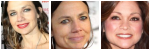

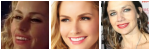

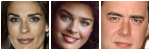

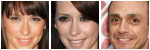

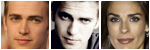

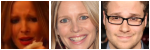

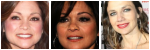

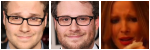

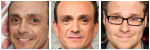

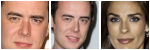

In [5]:

batch = data.getBatch(14, 'train')
print('batch = {aImg, pImg, nImg}: ', batch)
printTriplets(batch)

In [6]:
require 'nn'
alexnet = torch.load('alexnetowtbn_epoch55_cpu.t7')

In [7]:
function createModel(alexnet)
--     local alexnet = createModelAlex()
    --convNet = createModelAlex()
    local alexnet = alexnet:clone()
    alexnet:evaluate()
    alexnet:get(2):remove()
    alexnet:get(2):remove()
    alexnet:get(2):remove()
    alexnet:get(2):remove()

    convNet = alexnet
    convNet:get(2):add(nn.View(4096))
    convNet:get(2):add(nn.Linear(4096, 128))
    convNet:get(2):add(nn.Normalize(2))
    convNetPos = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(convNet)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)
    return parallel
end

function createModelTrip()
    embeddingSize = 3
    convNet = nn.Sequential()
    convNet:add(nn.SpatialConvolution(3, 8, 5, 5))
    convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
    convNet:add(nn.ReLU())
    convNet:add(nn.SpatialConvolution(8, 8, 5, 5))
    convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
    convNet:add(nn.ReLU())
    convNet:add(nn.View(8*2*2))
    convNet:add(nn.Linear(8*2*2, embeddingSize))
    convNet:add(nn.BatchNormalization(embeddingSize))
    
    convNetPos = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(convNet)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)
    return parallel:cuda()
end


function computeSimilarity(x, y)
--     -- use L2 norm distance
--     diff = x - y
--     return diff:norm(2,1):pow(2)
--     local dist_sum = 0
--     for i = 1, 128 do
--         dist_sum += x[i] 
    return torch.dist(x, y)
end

In [8]:
imgDim = 224

local conv = nn.SpatialConvolutionMM
local relu = nn.ReLU
local mp = nn.SpatialMaxPooling

function createModelVGG()
   local net = nn.Sequential()

   net:add(conv(3, 64, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(64, 64, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(64, 128, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(128, 128, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(128, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(256, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))

   -- Validate shape with:
   -- net:add(nn.Reshape(25088))

   net:add(nn.View(25088))
   net:add(nn.Linear(25088, 4096))
   net:add(relu(true))

   net:add(nn.Linear(4096, 128))
   net:add(nn.Normalize(2))
    
    convNetPos = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(net)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)

    return parallel
end

function createModelAlex()
    local net = nn.Sequential()
    local fb1 = nn.Sequential()
    fb1:add(nn.SpatialConvolution(3,64,11,11,4,4,2,2))       -- 224 -> 55
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   -- 55 ->  27
    fb1:add(nn.SpatialConvolution(64,192,5,5,1,1,2,2))       --  27 -> 27
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   --  27 ->  13
    fb1:add(nn.SpatialConvolution(192,384,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialConvolution(384,256,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialConvolution(256,256,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   -- 13 -> 6

    local classifier = nn.Sequential()
    classifier:add(nn.View(256*6*6))
    classifier:add(nn.Dropout(0.5))
    classifier:add(nn.Linear(256*6*6, 4096))
    classifier:add(nn.Threshold(0, 1e-6))
    classifier:add(nn.Dropout(0.5))
--     classifier:add(nn.View(4096))
    classifier:add(nn.Linear(4096, 128))
    classifier:add(nn.Normalize(2))
    
    net:add(fb1)
    net:add(classifier)
    return net
end

In [9]:
require 'nn'

--Load the AlexNet model
meanStd = torch.load('alexnetowtbn_meanStd.t7')

-- Pre-process the image channel by channel.
function preprocess(im)
    local output_image = image.scale(im:clone(), 224, 224)
    for i = 1, 3 do -- channels
        output_image[{{i},{},{}}]:add(-meanStd.mean[i])
        output_image[{{i},{},{}}]:div(meanStd.std[i])
    end
    return output_image
end

In [10]:
require 'nn'
require 'TripletEmbedding'

local criterion = nn.TripletEmbeddingCriterion()
if cuda == 1 then
    criterion = criterion:cuda()
end

function trainModel(model, opt)
    if cuda == 1 then
        print("loading model onto GPU")
        model = model:cuda()
    end
    
    -- Get all the parameters (and gradients) of the model in a single vector.
    print("getting params")
    -- local params, gradParams = model:getParameters()
    local singleNet = model.modules[1]
    local opt = opt or {}
    local batchSize = opt.batchSize or 10  -- The bigger the batch size the most accurate the gradients.
    local numEpochs = opt.numEpochs or 3
    print("getting batches")
    local trainBatches = data.getNbOfBatches(batchSize).train
    print('trainBatches: ', trainBatches)
    local numEpochs = trainBatches
    -- Go over the training data this number of times.
    local inputs = data.getBatch(1, 'train')
     for epoch = 1, 10 do
        local sum_loss = 0
        local correct = 0
--         local inputs = data.getBatch(1, 'train')

        -- Run over the training set samples.
        -- set internal var Train=True so that layers like Dropout behave correctly. Also see :evaluate()
        
--         model:training()
        
        -- 2. Perform the forward pass (prediction mode).
        --:view(1, 3, 224, 224)
        -- Ancore training samples/images
        local imageDim = 20
        local batch = 10
        aImgs = torch.rand(batch, 3, imageDim, imageDim):cuda()
        pImgs = torch.rand(batch, 3, imageDim, imageDim):cuda()
        -- Negative training samples/images
        nImgs = torch.rand(batch, 3, imageDim, imageDim):cuda()
--         print(nImgs)
        
        
        wrapperTotal = torch.Tensor(3, 10, 3, imageDim, imageDim)
        
        for apn = 1, 3 do
            for batchN = 1, batchSize do
                wrapper = torch.Tensor(1, 3, imageDim, imageDim)
                wrapper[1] = image.scale(inputs[apn][batchN], imageDim, imageDim)
                wrapperTotal[apn][batchSize] = wrapper
            end
        end
--         wrapperTotal = {inputs[1], inputs[2], inputs[3]}
--         wrapperTotal = inputs
        
--         print(image.scale(inputs[1], imageDim, imageDim))
--         print('haha')
        if cuda == 1 then
            wrapperTotal = wrapperTotal:cuda()
        end
--         print(inputs)
--         print(inputs:size())
--         print({wrapperTotal[1], wrapperTotal[2], wrapperTotal[3]})
--         local predictions = model:forward({wrapperTotal[1], wrapperTotal[2], wrapperTotal[3]})
        print({aImgs, pImgs, nImgs})
        local predictions = model:forward({aImgs, pImgs, nImgs})
--         print('haha1')
        print(predictions)
        --print("passed")
        -- 3. Evaluate results.
        --for i = 1, predictions:size(1) do
        --    local _, predicted_label = predictions[i]:max(1)
        --    if predicted_label[1] == labels[i] then correct = correct + 1 end
        --end
        local sum_loss = sum_loss + criterion:forward(predictions)
--         print("passed stage 2")
        -- TODO: need to figure out how to change this to accomandate the BCECriterion
        -- 4. Perform the backward pass (compute derivatives).
        -- This zeroes-out all the parameters inside the model pointed by variable params.
        
--          print("passed stage 3")
        -- This internally computes the gradients with respect to the parameters pointed by gradParams.
        local gradPredictions = criterion:backward(predictions)
        model:zeroGradParameters()
--          print("passed stage 4")
        --{wrapper, wrapper2, wrapper3}
        model:backward({aImgs, pImgs, nImgs}, gradPredictions)
        model:updateParameters(0.01)
--          print("passed stage 5")
         -- 5. Perform the SGD update.
        if epoch % 100 == 0 then
            model:updateParameters(0.01)
        end
        
        if epoch % 10 == 0 then  -- Print this every 10 epochs.
            print(('train epoch=%d, avg-loss=%.6f')
                :format(epoch, sum_loss / epoch))
        end

        -- Run over the validation set for evaluation.
        print(epoch)
        itorch.image({image.scale(inputs[1][1], 48, 48), image.scale(inputs[2][1], 48, 48), 
                image.scale(inputs[3][1], 48, 48)})
        
        if epoch == 1 then
            print(predictions[1][1])
        end
        
        local ap = computeSimilarity(predictions[1][1], predictions[2][1])
        local an = computeSimilarity(predictions[1][1], predictions[3][1])
        print(('\na-->p %.4f'):format(ap))
        print(('\na-->n %.4f'):format(an))
        --print(('\nvalidation accuracy at epoch = %d is %.4f'):format(epoch, validation_accuracy))
    end
end

In [11]:
--model = createModelTrip()


In [12]:
--trainModel(model:clone(), {})

In [11]:
--------------------------------------------------------------------------------
-- Fresh embedding training example
--------------------------------------------------------------------------------
-- Alfredo Canziani, Apr 15
--------------------------------------------------------------------------------

-- package.path = "../?.lua;" .. package.path

require 'nn'
require 'TripletEmbedding'
colour = require 'trepl.colorize'
local b = colour.blue

torch.manualSeed(0)

local learningRate = 0.1
local batchSize = 10
local embeddingSize = 3
--local imgSize = 96
local imgSize = 120
local trainBatches = data.getNbOfBatches(batchSize).train
print('trainBatches = ' .. trainBatches)




-- Network definition
-- convNet = nn.Sequential()
-- convNet:add(nn.SpatialConvolution(3, 8, 5, 5))
-- convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
-- convNet:add(nn.ReLU())
-- convNet:add(nn.SpatialConvolution(8, 8, 5, 5))
-- convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
-- convNet:add(nn.ReLU())
-- convNet:add(nn.View(8*2*2))
-- convNet:add(nn.Linear(8*2*2, embeddingSize))
-- convNet:add(nn.BatchNormalization(embeddingSize))

-- convNetPos = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
-- convNetNeg = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')

-- -- Parallel container
-- parallel = nn.ParallelTable()
-- parallel:add(convNet)
-- parallel:add(convNetPos)
-- parallel:add(convNetNeg)
-- parallel = parallel:cuda()

local conv = nn.SpatialConvolutionMM
local sbn = nn.SpatialBatchNormalization
local relu = nn.ReLU
local mp = nn.SpatialMaxPooling

 local net = nn.Sequential()

   net:add(conv(3, 64, 3,3, 1,1, 1,1))
   net:add(sbn(64))
   net:add(relu(true))
   net:add(conv(64, 64, 3,3, 1,1, 1,1))
   net:add(sbn(64))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(64, 128, 3,3, 1,1, 1,1))
   net:add(sbn(128))
   net:add(relu(true))
   net:add(conv(128, 128, 3,3, 1,1, 1,1))
   net:add(sbn(128))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(128, 256, 3,3, 1,1, 1,1))
   net:add(sbn(256))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(sbn(256))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(sbn(256))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(256, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))

   -- Validate shape with:
   net:add(nn.Reshape(4608))

   net:add(nn.View(4608))
   net:add(nn.Linear(4608, 1024))
   net:add(relu(true))

   net:add(nn.Linear(1024, 64))
   net:add(nn.Normalize(2))
    
    convNetPos = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(net)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)
    parallel = parallel:cuda()
-- print(b('Fresh-embeddings-computation network:')); print(parallel)

-- Cost function

loss = nn.TripletEmbeddingCriterion()
loss = loss:cuda()
local sumErr = 0
local sumMeanP = 0
local sumMeanN = 0
--trainBatches = trainBatches/2
local printVal = trainBatches/3
local epochsTotal = 20
local file = io.open("stats" .. tostring(epochsTotal) .. ".txt", "a")

for epoch = 1, epochsTotal do
    for i = 1, trainBatches do
        --print(i .. " " .. trainBatches)
        local inputs = data.getBatch(i, 'train')

        local resize_inputs = {torch.Tensor(batchSize, 3, imgSize, imgSize),
            torch.Tensor(batchSize, 3, imgSize, imgSize),
            torch.Tensor(batchSize, 3, imgSize, imgSize)}

        for apn = 1, 3 do
            for imgN = 1, batchSize do
                resize_inputs[apn][imgN] = image.scale(inputs[apn][imgN], imgSize, imgSize)
            end
        end
        --print('pass')
        aImgs = resize_inputs[1]
        -- Positive training samples/images
        pImgs = resize_inputs[2]
        -- Negative training samples/images
        nImgs = resize_inputs[3]
        
        local inputs = {aImgs, pImgs, nImgs}
       predict = parallel:forward({aImgs:cuda(), pImgs:cuda(), nImgs:cuda()})
        --print(inputs)
       err = loss:forward(predict)
       sumErr = sumErr + err
       errGrad = loss:backward(predict)
       parallel:zeroGradParameters()
       parallel:backward({aImgs:cuda(), pImgs:cuda(), nImgs:cuda()}, errGrad)

       parallel:updateParameters(learningRate)
        
        local mean_ap = 0
        local mean_an = 0
        for j = 1, batchSize do
            local ap = computeSimilarity(predict[1][j], predict[2][j])
            local an = computeSimilarity(predict[1][j], predict[3][j])
            mean_ap = mean_ap + ap
            mean_an = mean_an + an
        end
        mean_ap = mean_ap / batchSize
        mean_an = mean_an / batchSize
        sumMeanP = sumMeanP + mean_ap
        sumMeanN = sumMeanN + mean_an

        if i==trainBatches/3 or i==2*(trainBatches/3) or i==trainBatches then  --  i%printVal == 0 then
            print(colour.green('Epoch ' .. epoch))
            print(('\na-->p %.6f'):format(sumMeanP/printVal))
            print(('\na-->n %.6f'):format(sumMeanN/printVal))
            print(colour.red('loss: '), ('%.6f'):format(sumErr/printVal))
            file:write(epoch)
            file:write(',')
            file:write(('%.6f,'):format(sumMeanP/printVal))
            file:write(('%.6f,'):format(sumMeanN/printVal))
            file:write(('%.6f\n'):format(sumErr/printVal))
            file:flush()
            sumMeanP = 0
            sumMeanN = 0
            sumErr = 0
        end

            --    print(b('gradInput[1]:')); print(errGrad[1])\
    end
    
     if epoch == epochsTotal/4 then
            learningRate = .01
        elseif epoch == (epochsTotal/10)*5 then
            learningRate = .001
        elseif epoch == (epochsTotal/10)*8 then
            learningRate = .0001
        elseif epoch == epochsTotal-(epochsTotal/100) then
            learningRate = .00001
        end
end

file:close()
local filename = "VGG_small_" .. tostring(epochsTotal) .. ".t7"
torch.save(tostring(filename), parallel)

trainBatches = 5874	


Epoch 1	

a-->p 0.265265	

a-->n 0.338442	
loss: 	0.169152	


Epoch 1	

a-->p 0.328813	

a-->n 0.468860	
loss: 	0.135115	


Epoch 1	

a-->p 0.349005	

a-->n 0.554137	
loss: 	0.110566	


Epoch 2	

a-->p 0.341084	

a-->n 0.597245	
loss: 	0.094194	


Epoch 2	

a-->p 0.351974	

a-->n 0.628097	
loss: 	0.089156	


Epoch 2	

a-->p 0.353142	

a-->n 0.668859	
loss: 	0.078126	


Epoch 3	



a-->p 0.367127	

a-->n 0.718725	
loss: 	0.069069	


Epoch 3	

a-->p 0.365399	

a-->n 0.735172	
loss: 	0.064153	


Epoch 3	

a-->p 0.362890	

a-->n 0.744370	
loss: 	0.061243	


Epoch 4	

a-->p 0.376887	

a-->n 0.782733	
loss: 	0.057244	


Epoch 4	

a-->p 0.373507	

a-->n 0.786618	
loss: 	0.054596	


Epoch 4	

a-->p 0.383985	

a-->n 0.809793	
loss: 	0.052521	


Epoch 5	

a-->p 0.382042	

a-->n 0.817597	
loss: 	0.050236	


Epoch 5	

a-->p 0.382507	

a-->n 0.827324	
loss: 	0.048120	


Epoch 5	

a-->p 0.385395	

a-->n 0.828467	
loss: 	0.048637	


Epoch 6	

a-->p 0.386677	

a-->n 0.860928	
loss: 	0.041207	


Epoch 6	

a-->p 0.394691	

a-->n 0.895956	
loss: 	0.037658	


Epoch 6	

a-->p 0.400051	

a-->n 0.908627	
loss: 	0.035555	


Epoch 7	

a-->p 0.398882	

a-->n 0.914817	
loss: 	0.036169	


Epoch 7	

a-->p 0.400443	

a-->n 0.925884	
loss: 	0.034972	


Epoch 7	

a-->p 0.406431	

a-->n 0.942769	
loss: 	0.032934	


Epoch 8	

a-->p 0.404073	

a-->n 0.933951	
loss: 	0.034800	


Epoch 8	

a-->p 0.404567	



a-->n 0.934193	
loss: 	0.033475	


Epoch 8	

a-->p 0.408220	

a-->n 0.940147	
loss: 	0.032149	


Epoch 9	

a-->p 0.404281	

a-->n 0.935989	
loss: 	0.034053	


Epoch 9	

a-->p 0.408430	

a-->n 0.948694	
loss: 	0.031189	


Epoch 9	

a-->p 0.410082	

a-->n 0.957508	
loss: 	0.031258	


Epoch 10	

a-->p 0.407746	

a-->n 0.952853	
loss: 	0.031980	


Epoch 10	

a-->p 0.409547	

a-->n 0.957101	
loss: 	0.030002	


Epoch 10	

a-->p 0.410535	

a-->n 0.959233	
loss: 	0.030986	


Epoch 11	

a-->p 0.403732	

a-->n 0.939252	
loss: 	0.030991	


Epoch 11	

a-->p 0.405658	

a-->n 0.952028	
loss: 	0.028670	


Epoch 11	

a-->p 0.408686	

a-->n 0.965628	
loss: 	0.026424	


Epoch 12	

a-->p 0.413923	

a-->n 0.966583	
loss: 	0.029628	


Epoch 12	

a-->p 0.413965	

a-->n 0.973210	
loss: 	0.028617	


Epoch 12	

a-->p 0.413186	

a-->n 0.976579	
loss: 	0.028200	


Epoch 13	

a-->p 0.412529	

a-->n 0.968251	
loss: 	0.029691	


Epoch 13	

a-->p 0.411611	

a-->n 0.971082	
loss: 	0.028531	


Epoch 13	

a-->p 0.412648	

a-->n 0.979478	
loss: 	0.026559	


Epoch 14	

a-->p 0.415370	

a-->n 0.972726	
loss: 	0.030950	


Epoch 14	

a-->p 0.416884	

a-->n 0.976870	
loss: 	0.028117	


Epoch 14	

a-->p 0.415370	

a-->n 0.982313	
loss: 	0.027495	


Epoch 15	

a-->p 0.416715	

a-->n 0.974393	
loss: 	0.030019	


Epoch 15	

a-->p 0.415133	

a-->n 0.977336	
loss: 	0.027516	


Epoch 15	

a-->p 0.416939	

a-->n 0.984074	
loss: 	0.027059	


Epoch 16	

a-->p 0.418103	



a-->n 0.977817	
loss: 	0.029184	


Epoch 16	

a-->p 0.416691	

a-->n 0.983450	
loss: 	0.027442	


Epoch 16	

a-->p 0.418962	

a-->n 0.986219	
loss: 	0.027313	


Epoch 17	

a-->p 0.417207	

a-->n 0.980126	
loss: 	0.029332	


Epoch 17	

a-->p 0.416934	

a-->n 0.982816	
loss: 	0.027085	


Epoch 17	

a-->p 0.414273	

a-->n 0.985637	
loss: 	0.025972	


Epoch 18	

a-->p 0.417692	

a-->n 0.980080	


loss: 	0.029062	


Epoch 18	

a-->p 0.418702	

a-->n 0.983077	
loss: 	0.027961	


Epoch 18	

a-->p 0.414804	

a-->n 0.985902	
loss: 	0.026490	


Epoch 19	

a-->p 0.419856	

a-->n 0.980330	
loss: 	0.029730	


Epoch 19	

a-->p 0.417568	

a-->n 0.983108	
loss: 	0.026973	


Epoch 19	

a-->p 0.417023	

a-->n 0.985931	
loss: 	0.027074	


Epoch 20	

a-->p 0.417105	



a-->n 0.980334	
loss: 	0.028605	


Epoch 20	

a-->p 0.417532	

a-->n 0.983220	
loss: 	0.026886	


Epoch 20	

a-->p 0.415650	

a-->n 0.986240	
loss: 	0.026586	
